In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

In [2]:
%run 'yolov3_tf2.ipynb'

In [3]:
%run 'utils.ipynb'

In [4]:
model_size = (416, 416, 3)
class_name = './data/classes.txt'
max_output_size = 40
max_output_size_per_class = 20
iou_threshold = 0.5
confidence_threshold = 0.5

cfgfile = 'cfg/yolov3.cfg'
weightfile = 'weights/yolov3_weights.tf'
img_path = 'img/host-a004_cam0_1232815252251064006.jpeg'

In [5]:
num_classes = 9
model = YOLOv3Net(cfgfile,model_size,num_classes)
model.load_weights(weightfile)

class_names = load_class_names(class_name)
    
#image = cv2.imread(img_path)
image = plt.imread(img_path)
image = np.array(image)
image = tf.expand_dims(image, 0)

resized_frame = resize_image(image, (model_size[0],model_size[1]))
pred = model.predict(resized_frame)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv (TensorFlow [(None, 416, 416, 3) 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 416, 416, 32) 864         tf_op_layer_truediv[0][0]        
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, 416, 416, 32) 128         conv_0[0][0]                     
______________________________________________________________________________________________

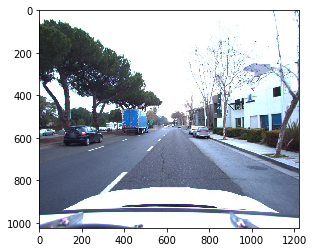

In [6]:
boxes, scores, classes, nums = output_boxes(
    pred, model_size,
    max_output_size=max_output_size,
    max_output_size_per_class=max_output_size_per_class,
    iou_threshold=iou_threshold,
    confidence_threshold=confidence_threshold)
image = np.squeeze(image)
img = draw_outputs(image, boxes, scores, classes, nums, class_names)
plt.imshow(img)

In [ ]:
#win_name = 'Image detection'
#cv2.imshow(win_name, img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

#cv2.imwrite('final_img/host-a004_cam0_1232815252251064006.jpeg', img)